<a href="https://colab.research.google.com/github/colinjhorgan/MLTSAFinalProject/blob/main/Data%20Exploration/DataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import pylab as plt
%pylab inline

import seaborn as sns

from statsmodels.distributions.empirical_distribution import ECDF as ecdf

from scipy.signal import resample_poly

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/3. MSDS Courses/Machine Learning Time Series/MLTSA22 Project


/content/gdrive/.shortcut-targets-by-id/1LVVsMd6gKniMsFyJ0AQvztE0uDjwU-Fo/MLTSA22 Project


In [ ]:
ls Data

ECDF_Cartesian.csv       image_arrayminmax.npy  Phones_accelerometer.csv
ECDF_Spherical.csv       image_array.npy        Time_Domain_Features.csv
FFT_features.csv         image_array_polar.npy  Watch_accelerometer.csv
image_array_clipped.npy  image_labels.npy


In [ ]:
#Read in data
path = 'Data/Phones_accelerometer.csv'
paccel = pd.read_csv(path, index_col=0)

paccel.tail(8)

,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
Index,,,,,,,,,
129045,1424778553265,92263731712000,1.379043,0.306454,9.959755,i,samsungold,samsungold_2,bike
129046,1424778553286,92263752250000,1.532270,0.153227,9.959755,i,samsungold,samsungold_2,bike
129047,1424778553306,92263772270000,1.379043,0.000000,9.959755,i,samsungold,samsungold_2,bike
129048,1424778553315,92263781761000,1.379043,0.153227,9.959755,i,samsungold,samsungold_2,bike
129049,1424778553346,92263812248000,1.379043,0.153227,9.806528,i,samsungold,samsungold_2,bike
129050,1424778553366,92263832267000,1.532270,0.153227,9.806528,i,samsungold,samsungold_2,bike
129051,1424778553386,92263852409000,1.532270,0.000000,9.959755,i,samsungold,samsungold_2,bike
129052,1424778553395,92263861839000,1.379043,0.000000,9.959755,i,samsungold,samsungold_2,bike


In [ ]:
#gt contains nan values so we impute them with 'no_task'
paccel['gt'] = paccel['gt'].fillna('no_task')

#Let every user/model/device/gt be called a trial. We give each trial a unique id.
paccel['trial'] = paccel[['User','Model','Device','gt']].astype(str).sum(axis=1)
paccel['id'] = pd.Categorical(paccel['trial']).codes
print(f'Number of unique trials: {paccel.id.max()+1}')

Number of unique trials: 485


In [ ]:
#Plot histograms
def hist_xyz(df, trial_id, corr=False):
  '''
  Consumes a dataframe and id of a trial and plots histograms of xyz axes.
  If corr is true, then it will print out the dimension-wise pearson correlation
  matrix.
  '''

  data = df.loc[df.id == trial_id]
  title = data['gt'].mode()
  dim_list = ['xmm','ymm','zmm']

  fig, axs = pl.subplots(1, 3, figsize=(12,8))

  for d in range(0,3):
    axs[d].hist(data[dim_list[d]],#(data[dim_list[d]] - data[dim_list[d]].mean()) / data[dim_list[d]].std(),
                log=True)
    axs[d].set_title(f'{dim_list[d]}_axis')

  fig.suptitle(f'Task: {title[0]}', y=.97);

  if corr:
    print(data[dim_list].corr())

          xmm       ymm       zmm
xmm  1.000000 -0.070978  0.845381
ymm -0.070978  1.000000 -0.320840
zmm  0.845381 -0.320840  1.000000


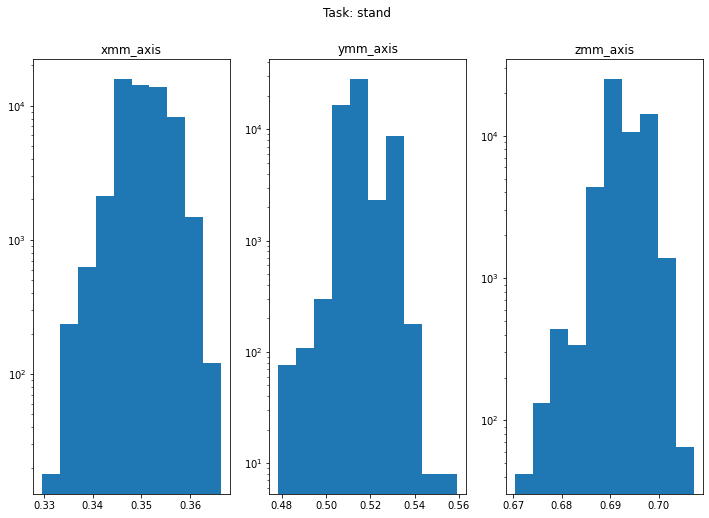

In [ ]:
hist_xyz(paccel, 12,True)

          xmm       ymm       zmm
xmm  1.000000 -0.155353 -0.616389
ymm -0.155353  1.000000  0.021959
zmm -0.616389  0.021959  1.000000


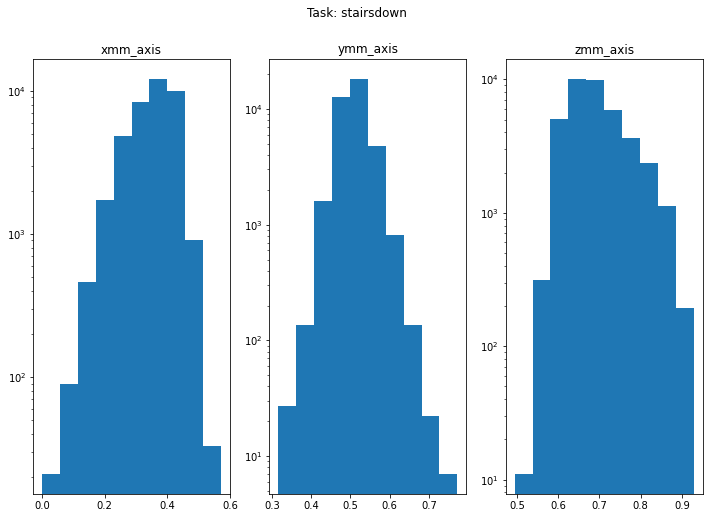

In [ ]:
hist_xyz(paccel, 10, True)

          xmm       ymm       zmm
xmm  1.000000 -0.178339 -0.139328
ymm -0.178339  1.000000 -0.023400
zmm -0.139328 -0.023400  1.000000


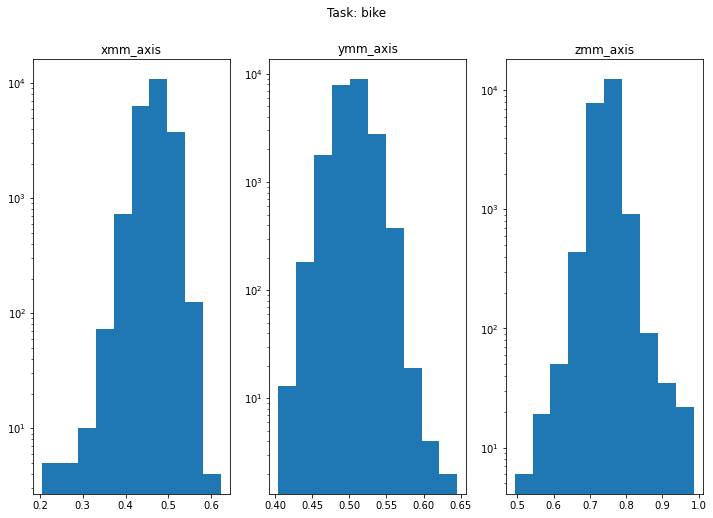

In [ ]:
hist_xyz(paccel, 478, True)

In [ ]:
paccel[["x", "y", "z"]].min(axis = 1)

Index
0        -5.958191
1        -5.952240
2        -5.995087
3        -5.942718
4        -5.991516
            ...   
129048    0.153227
129049    0.153227
129050    0.153227
129051    0.000000
129052    0.000000
Length: 13062475, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fbb413910>]],
      dtype=object)

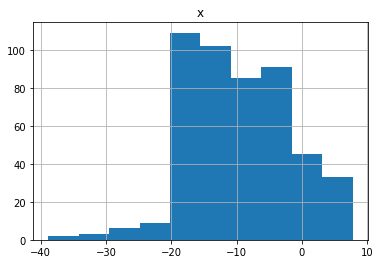

In [ ]:
paccel.groupby('id').min()[["x"]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fba534610>]],
      dtype=object)

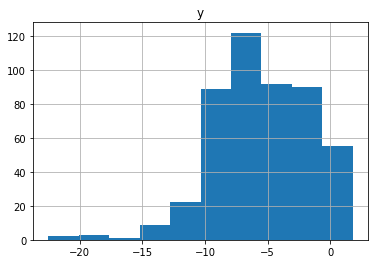

In [ ]:
paccel.groupby('id').min()[["y"]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fba45d050>]],
      dtype=object)

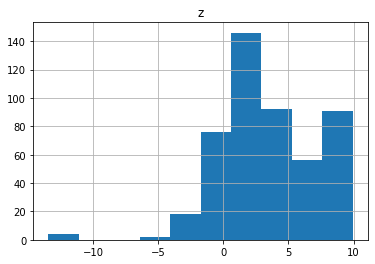

In [ ]:
paccel.groupby('id').min()[["z"]].hist()

In [ ]:
paccel.groupby("id").count()

,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt,trial
id,,,,,,,,,,
0,36676,36676,36676,36676,36676,36676,36676,36676,36676,36676
1,32917,32917,32917,32917,32917,32917,32917,32917,32917,32917
2,59954,59954,59954,59954,59954,59954,59954,59954,59954,59954
3,44990,44990,44990,44990,44990,44990,44990,44990,44990,44990
4,43174,43174,43174,43174,43174,43174,43174,43174,43174,43174
...,...,...,...,...,...,...,...,...,...,...
480,13216,13216,13216,13216,13216,13216,13216,13216,13216,13216
481,19086,19086,19086,19086,19086,19086,19086,19086,19086,19086
482,19750,19750,19750,19750,19750,19750,19750,19750,19750,19750


In [ ]:
df_ = paccel[["x", "y", "z"]]

In [ ]:
df_.clip(-20, 20, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:7430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._clip_with_scalar(lower, upper, inplace=inplace)


In [ ]:
df_ = (df_ + 20 ) / 40

In [ ]:
paccel["xmm"] = df_["x"]
paccel["ymm"] = df_["y"]
paccel["zmm"] = df_["z"]

# ECDF Visualization

In [ ]:
x = paccel['x'].loc[paccel.id == 0]
xs = np.sort(x)
F = ecdf(xs)

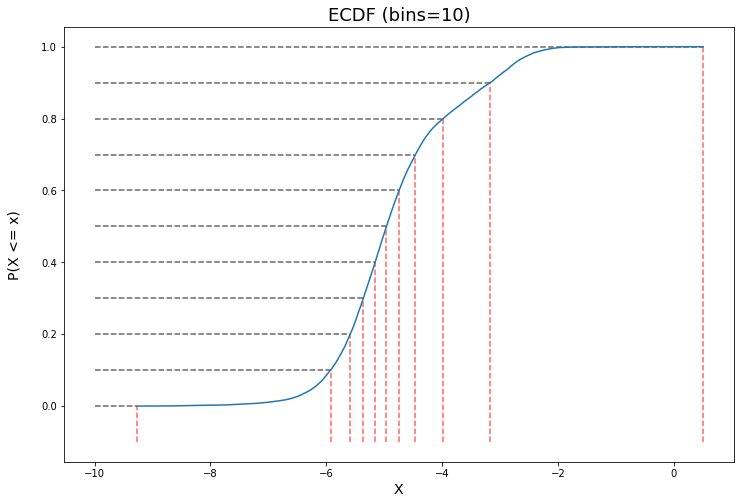

In [ ]:
bins = np.linspace(0, 1, 11)

pl.figure(figsize=(12,8))
pl.plot(xs, F(xs))
pl.hlines(bins,-10, xs[np.searchsorted(F(xs), bins)], ls='--', alpha=.6)
pl.vlines(xs[np.searchsorted(F(xs), bins)], -.1, bins, ls='--', alpha=.6, color='red')
pl.xlabel('X', fontsize=14)
pl.ylabel('P(X <= x)', fontsize=14, labelpad=20)
pl.title('ECDF (bins=10)', fontsize=18);

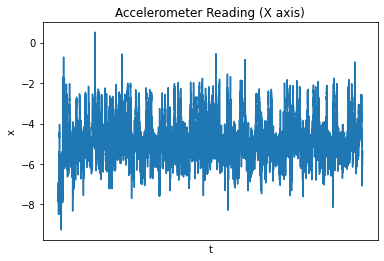

In [ ]:
pl.plot(x.values)
pl.xticks([])
pl.xlabel('t')
pl.ylabel('x')
pl.title('Accelerometer Reading (X axis)');

In [ ]:
ecdf = pd.read_csv('/content/gdrive/MyDrive/3. MSDS Courses/Machine Learning Time Series/MLTSA22 Project/Data/ECDF_Cartesian.csv')

In [ ]:
search = paccel.groupby('id').first().reset_index()

In [ ]:
search

,id,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt,trial
0,0,1424698217675,1424698215675995642,-7.291199,2.341232,6.313171,a,nexus4,nexus4_1,bike,anexus4nexus4_1bike
1,1,1424696936998,1424696935005288835,-6.166473,0.081070,7.977051,a,nexus4,nexus4_1,no_task,anexus4nexus4_1no_task
2,2,1424696945006,1424696943017983841,-0.448822,-0.096268,10.301483,a,nexus4,nexus4_1,sit,anexus4nexus4_1sit
3,3,1424697674436,1424697672392981833,-5.995087,2.561417,9.113678,a,nexus4,nexus4_1,stairsdown,anexus4nexus4_1stairsdown
4,4,1424697665003,1424697663324714604,-4.332397,-0.190292,6.814240,a,nexus4,nexus4_1,stairsup,anexus4nexus4_1stairsup
...,...,...,...,...,...,...,...,...,...,...,...
480,480,1424776683406,90393872154000,4.903264,0.306454,8.733939,i,samsungold,samsungold_2,sit,isamsungoldsamsungold_2sit
481,481,1424777465975,91176442283000,-1.379043,-1.379043,9.653301,i,samsungold,samsungold_2,stairsdown,isamsungoldsamsungold_2stairsdown
482,482,1424777413924,91124391533000,-0.919362,-0.612908,9.806528,i,samsungold,samsungold_2,stairsup,isamsungoldsamsungold_2stairsup
483,483,1424776359595,90070062339000,-0.612908,-0.306454,9.806528,i,samsungold,samsungold_2,stand,isamsungoldsamsungold_2stand


In [ ]:
ecdf.head(10)

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_10,gt
0,-1.036672,-0.189259,-0.141652,-0.099996,-0.054769,-0.007161,0.117808,0.176127,0.220164,0.620067,...,-0.152755,-0.113479,-0.083724,-0.053969,-0.009933,0.092423,0.148362,0.193589,0.587541,stand
1,-13.817284,-3.694757,-2.725945,-2.001122,-1.566705,-0.466973,3.379706,4.297339,4.360419,6.558692,...,-2.619598,-1.449646,-0.668884,-0.323730,0.777191,1.484162,1.528199,1.578186,15.658081,no_task
2,-0.849502,-0.072311,-0.042556,-0.024703,-0.009231,0.006241,0.022904,0.043137,0.077653,0.406144,...,-0.055981,-0.034558,-0.019086,-0.005994,0.007098,0.020190,0.034473,0.055896,0.293933,sit
3,-12.232441,-2.601460,-1.414844,-0.720966,-0.077076,0.622753,1.309490,1.930767,2.487774,6.545116,...,-3.175324,-2.361237,-1.460266,-0.743775,-0.099884,0.634460,1.807983,4.063385,10.016693,walk
4,-10.841441,-3.639629,-2.047161,-0.814129,0.068989,0.868794,1.613850,2.302967,3.028981,5.559315,...,-2.672350,-1.954669,-1.271502,-0.620471,0.000806,0.686353,1.840833,3.273817,8.770094,stairsup
5,-14.567050,-3.849430,-2.105808,-0.823978,0.075802,0.798245,1.568295,2.416897,3.257168,9.269985,...,-3.106543,-2.184149,-1.492651,-0.845190,-0.126318,0.756799,1.979120,3.844141,15.353235,stairsdown
6,-4.467219,-1.083521,-0.734797,-0.496760,-0.276576,-0.049250,0.230443,0.661291,1.520605,5.303014,...,-0.932583,-0.551724,-0.282742,-0.070889,0.132633,0.349246,0.587284,0.890781,6.598911,bike
7,-0.844419,-0.210050,-0.157682,-0.107694,-0.041044,0.017275,0.117251,0.166048,0.217226,0.627840,...,-0.158464,-0.119188,-0.090624,-0.058489,-0.007311,0.100996,0.150984,0.196211,0.572309,stand
8,-13.240703,-3.756115,-2.882518,-2.118419,-1.561412,-0.336711,3.988423,4.243122,4.308583,4.759663,...,-2.517601,-1.466667,-0.806114,-0.269340,0.835152,1.476662,1.517128,1.565926,7.991737,no_task
9,-0.661595,-0.074833,-0.045079,-0.026036,-0.009373,0.006099,0.022762,0.045375,0.082271,0.430995,...,-0.055120,-0.033696,-0.019414,-0.006322,0.006770,0.019862,0.034144,0.054378,0.332881,sit


In [ ]:
test = pd.DataFrame()

for i in range(0,11):
  test[f'x{i+1}'] = [xs[np.searchsorted(F(xs), bins)][i]]

test

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,-9.259766,-5.923675,-5.584473,-5.358337,-5.153626,-4.959625,-4.740631,-4.458557,-3.978912,-3.168396,0.510467


In [ ]:
x = paccel['x'].loc[paccel.id==0]

x_new = resample_poly(x.values, 15050, x.values.shape[0])
x_new

array([-5.12914121, -7.7079721 , -6.87054131, ..., -5.7863166 ,
       -5.65032448, -6.41379353])

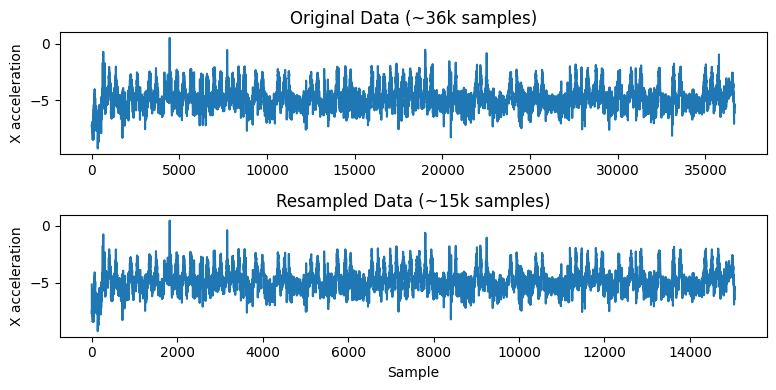

In [ ]:
plt.rcdefaults()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,4))

ax1.plot(x.values)
ax1.set_title('Original Data (~36k samples)')
ax1.set_ylabel('X acceleration')

ax2.plot(x_new)
ax2.set_title('Resampled Data (~15k samples)')
ax2.set_ylabel('X acceleration')
ax2.set_xlabel('Sample')

fig.tight_layout()